# More Neural Network Testing

In [9]:
# Libraries
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# Tensorflow aliases
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.regularizers import l2, l1
from tensorflow.keras.utils import plot_model

data = pd.read_csv('../parkinsons_updrs.csv')

# Drop the subject # column because it is useless
data = data.drop('subject#', axis=1)

X = data.drop(['motor_UPDRS', 'total_UPDRS'], axis=1)
y = data['total_UPDRS']

# Split into training and test sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Randomly select 10% of the training data to be the validation set
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
print(f"Original data: {len(X)}\nTraining set: {len(X_train)}\nValidation set: {len(X_val)}\nTesting set: {len(X_test)}")

# Weight regularization to keep the weights small
def build_model(neurons, layers, input_shape, activation='linear', regularizer=None, lam=0.01, dropout=False, drop_prob=0.2, summarize=False):
  model = Sequential()
  model.add(Flatten(input_shape=input_shape))
  if regularizer != None:
    for i in range(layers-1):
      model.add(Dense(neurons, activation=activation, kernel_regularizer=regularizer(lam)))
      if dropout:
        model.add(Dropout(drop_prob)) # randomly select nodes with probability drop_prob
  else:
    model.add(Dense(neurons, input_shape=input_shape))
    for i in range(layers-1):
      model.add(Dense(neurons, activation=activation))
      if dropout:
        model.add(Dropout(drop_prob))
  

  model.add(Dense(1))
  model.compile(loss='mae', optimizer='adam', metrics=['mae', 'mape', 'mse', tf.keras.metrics.RootMeanSquaredError()])

  if summarize:
    model.build()
    model.summary()
    
  return model

# Helper functions
def show_acc(h, e):
  plt.plot(range(e), h.history['mae'], label='Training')
  plt.plot(range(e), h.history['val_mae'], label='Validation')
  plt.ylim([0, np.max(h.history['mae'])+10])
  plt.legend()
  plt.show()

def build_and_plot(neurons, layers, input_shape, activation='linear', regularizer=None, lam=0.01, dropout=False, drop_prob=0.2, summarize=False, e=100, verbose=0):
  model = build_model(neurons, layers, input_shape, activation=activation, regularizer=regularizer, lam=lam, dropout=dropout, drop_prob=drop_prob, summarize=summarize)
  history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=e, verbose=verbose)
  show_acc(history, e)
  print("Max MAE: ", np.max(history.history['mae']))
  print("Min MAE: ", np.min(history.history['mae']))
  print("Test performance ", model.evaluate(X_test, y_test))
  return model, history

Original data: 5875
Training set: 3760
Validation set: 940
Testing set: 1175


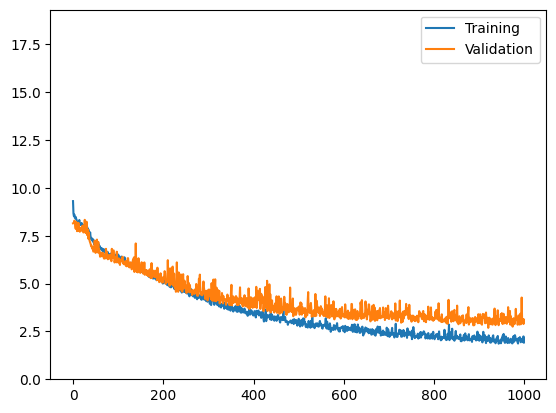

Max MAE:  9.305474281311035
Min MAE:  1.8576180934906006
37/37 [==============================] - 0s 624us/step - loss: 3.1171 - mae: 3.1171 - mape: 14.7134 - mse: 30.4435 - root_mean_squared_error: 5.5176
Test performance  [3.117072582244873, 3.117072582244873, 14.713414192199707, 30.44349479675293, 5.517562389373779]


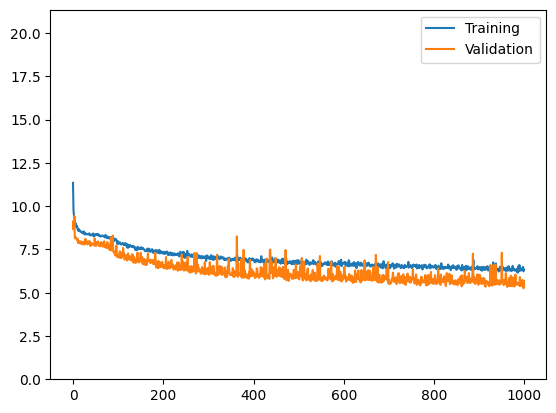

Max MAE:  11.342367172241211
Min MAE:  6.150381565093994
37/37 [==============================] - 0s 577us/step - loss: 5.8274 - mae: 5.8274 - mape: 24.7142 - mse: 68.0077 - root_mean_squared_error: 8.2467
Test performance  [5.827380657196045, 5.827380657196045, 24.714174270629883, 68.00765991210938, 8.246675491333008]


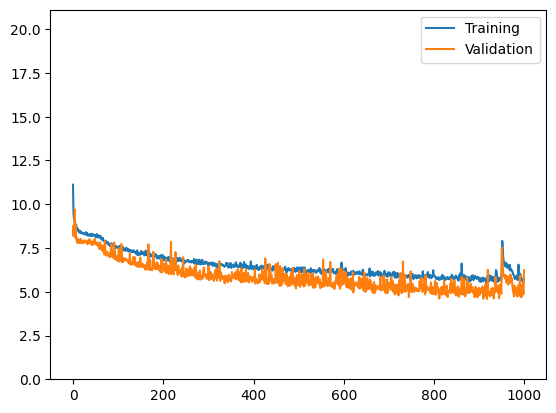

Max MAE:  11.116005897521973
Min MAE:  5.517986297607422
37/37 [==============================] - 0s 576us/step - loss: 6.3948 - mae: 6.3948 - mape: 28.8856 - mse: 76.6469 - root_mean_squared_error: 8.7548
Test performance  [6.394841194152832, 6.394841194152832, 28.885574340820312, 76.6468505859375, 8.7548189163208]


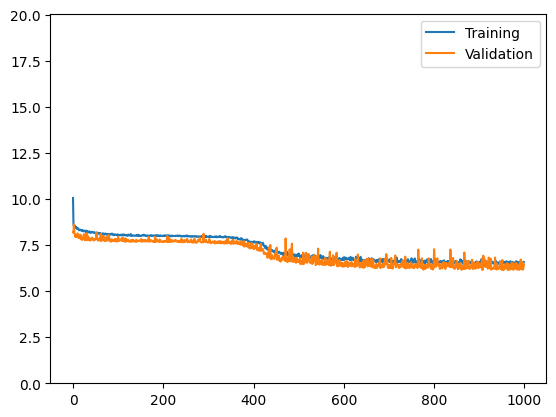

Max MAE:  10.056045532226562
Min MAE:  6.421935558319092
37/37 [==============================] - 0s 506us/step - loss: 6.7867 - mae: 6.3388 - mape: 24.0416 - mse: 81.5418 - root_mean_squared_error: 9.0301
Test performance  [6.786710262298584, 6.3388495445251465, 24.041561126708984, 81.54182434082031, 9.030051231384277]


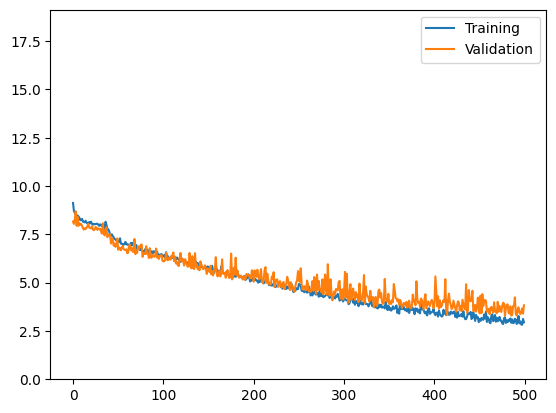

Max MAE:  9.122982025146484
Min MAE:  2.81884503364563
37/37 [==============================] - 0s 561us/step - loss: 3.6883 - mae: 3.6883 - mape: 15.0769 - mse: 39.5412 - root_mean_squared_error: 6.2882
Test performance  [3.6882667541503906, 3.6882667541503906, 15.076868057250977, 39.54116439819336, 6.288176536560059]


In [10]:
# Model 32:
model_32, history_32 = build_and_plot(neurons=128, layers=4, input_shape=(X_train.shape[1],), activation='elu', dropout=False, e=1000, verbose=0)


# Model 45:
model_45, history_45 = build_and_plot(neurons=128, layers=4, input_shape=(X_train.shape[1],), activation='elu', dropout=True, drop_prob=0.4, e=1000, verbose=0)


# Model 44:
model_44, history_44 = build_and_plot(neurons=128, layers=4, input_shape=(X_train.shape[1],), activation='elu', dropout=True, drop_prob=0.3, e=1000, verbose=0)


# Model 35:
model_35, history_35 = build_and_plot(neurons=128, layers=4, input_shape=(X_train.shape[1],), regularizer=l2, activation='elu', dropout=False, e=1000, verbose=0)


# Model 31:
model_31, history_31 = build_and_plot(neurons=128, layers=4, input_shape=(X_train.shape[1],), activation='elu', dropout=False, e=500, verbose=0)

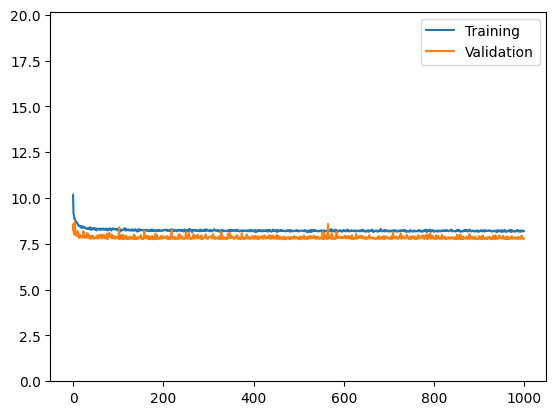

Max MAE:  10.176010131835938
Min MAE:  8.135869979858398
37/37 [==============================] - 0s 537us/step - loss: 7.9642 - mae: 7.8424 - mape: 31.8322 - mse: 99.0114 - root_mean_squared_error: 9.9504
Test performance  [7.9642229080200195, 7.842392921447754, 31.83217430114746, 99.01139831542969, 9.950447082519531]


In [11]:
# Dropout with regularization
model_drop_reg = build_and_plot(neurons=128, layers=4, input_shape=(X_train.shape[1],), regularizer=l2, lam=0.01, activation='elu', dropout=True, e=1000, verbose=0)